In [ ]:
import numpy as np

eval_data_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_data_complete.npy")
eval_label_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_label_complete.npy")

In [ ]:
eval_data = eval_data_original[10:-50]
eval_label = eval_label_original[10:-50]

test_data = np.concatenate((eval_data_original[:10], eval_data_original[-50:]))
test_label = np.concatenate((eval_label_original[:10], eval_label_original[-50:]))

eval_data_original = 0
eval_label_original = 0

In [ ]:
eval_data = np.concatenate((eval_data[:337], eval_data[:337], eval_data[:337], eval_data[:337], eval_data))
eval_label = np.concatenate((eval_label[:337], eval_label[:337], eval_label[:337], eval_label[:337], eval_label))
print(eval_data.shape)
print(eval_label.shape)

(3483, 22, 15000)
(3483,)


In [ ]:
idx = np.random.permutation(len(eval_data))
eval_data,eval_label = eval_data[idx], eval_label[idx]
idx = 0

In [ ]:
from tensorflow.keras.utils import to_categorical

enc_labels = to_categorical(eval_label, num_classes=2)      
test_label = to_categorical(test_label, num_classes=2)           
eval_label= enc_labels
enc_labels = 0
print(eval_data.shape)
print(eval_label.shape)
print(eval_data.dtype)
print(eval_label.dtype)
print('training labels have been loaded')

bs,t,f = eval_data.shape

(3483, 22, 15000)
(3483, 2)
float32
float32
training labels have been loaded


In [ ]:
from pdb import set_trace
#import mne
import pandas as pd
import numpy as np
import math
import os
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, Dense, Activation, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


# ----------------------CHRONONET Testing-----------------------
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
inputsin= Input(shape=(t,f))
# ------------------First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputsin)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputsin)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputsin)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.45)(x)

# ----------------------Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.45)(x)

# ----------------------------------Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.45)(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)
res1_2 = concatenate([res1,res2],axis=2)
res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)
x = concatenate([res1,res2,res3])
x = GRU(32,activation='tanh')(x)

predictions = Dense(2,activation='softmax')(x)
model = Model(inputs=inputsin, outputs=predictions)

# learning rate to 0.00001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# learning rate to 0.0001
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
print(model.metrics_names)
print(model.summary())

# early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, mode='min', verbose=1, patience=25)                          #patience
mc = ModelCheckpoint('model3flipped_acc.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)        #filepath (save model as)
mces = ModelCheckpoint('model3flipped_loss.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)      #filepath (save model as)

# fit model
# hist=model.fit(eval_data,eval_label,validation_split=0.2,epochs=1000,batch_size=128,verbose=1,callbacks=[es, mc,mces],shuffle=False) #epochs #split #

# fit model (without early stopping)
# hist=model.fit(eval_data,eval_label,validation_split=0.2,epochs=20,batch_size=128,verbose=1,callbacks=[mc,mces],shuffle=False) #epochs #split #



print('The End')

[]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 11, 32)       960032      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 11, 32)       1920032     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 11, 32)       3840032     input_1[0][0]                    
___________________________________________________________________________________________

In [ ]:
model.load_weights("model3flipped_loss.hdf5") 

In [ ]:
hist=model.fit(eval_data,eval_label,validation_data=((test_data, test_label)),epochs=20,batch_size=32,verbose=1,callbacks=[mc,mces],shuffle=False) #epochs #split #


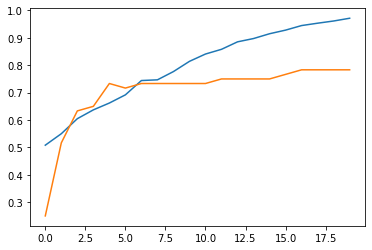

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

# 8-bit full integer quantization

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpcgrrds6h/assets


INFO:tensorflow:Assets written to: /tmp/tmpcgrrds6h/assets


In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("")
#tflite_models_dir.mkdir(exist_ok=True, parents=True)
'''
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
'''
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

6912384

In [ ]:
tflite_interpreter = tf.lite.Interpreter('model_quant.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()


#tflite_interpreter.resize_tensor_input(input_details[0]['index'], (60, 22, 15000))
#tflite_interpreter.resize_tensor_input(output_details[0]['index'], (60, 2))
tflite_interpreter.allocate_tensors()


predictions = []
for data in test_data:
  tflite_interpreter.set_tensor(input_details[0]['index'], [data])

  tflite_interpreter.invoke()

  tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
  print("Prediction results shape:", tflite_model_predictions.shape)
  predictions.append(tflite_model_predictions)

Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction

In [ ]:
print(f'{tflite_interpreter.get_input_details()},\n {tflite_interpreter.get_output_details()}')

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([    1,    22, 15000], dtype=int32), 'shape_signature': array([   -1,    22, 15000], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}],
 [{'name': 'StatefulPartitionedCall:0', 'index': 192, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
count = 0
for i in range(len(predictions)):
  if (predictions[i][0][0] > predictions[i][0][1]) and (test_label[i][0] == 1):
    count += 1
  elif (predictions[i][0][0] < predictions[i][0][1]) and (test_label[i][1] == 1):
    count += 1
print(f'total correct predictions = {count}')

total correct predictions = 47


In [ ]:
print(f'accuracy = {47/60}')

accuracy = 0.7833333333333333


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model_f = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpcjllcxe6/assets


INFO:tensorflow:Assets written to: /tmp/tmpcjllcxe6/assets


# 16-bit float quantization

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("")
#tflite_models_dir.mkdir(exist_ok=True, parents=True)
'''
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
'''
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_quant_f.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model_f)

13754288

In [ ]:
tflite_interpreter = tf.lite.Interpreter('model_quant_f.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()


#tflite_interpreter.resize_tensor_input(input_details[0]['index'], (60, 22, 15000))
#tflite_interpreter.resize_tensor_input(output_details[0]['index'], (60, 2))
tflite_interpreter.allocate_tensors()


predictions = []
for data in test_data:
  tflite_interpreter.set_tensor(input_details[0]['index'], [data])

  tflite_interpreter.invoke()

  tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
  print("Prediction results shape:", tflite_model_predictions.shape)
  predictions.append(tflite_model_predictions)

Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction results shape: (1, 2)
Prediction

In [ ]:
count = 0
for i in range(len(predictions)):
  if (predictions[i][0][0] > predictions[i][0][1]) and (test_label[i][0] == 1):
    count += 1
  elif (predictions[i][0][0] < predictions[i][0][1]) and (test_label[i][1] == 1):
    count += 1
print(f'total correct predictions = {count}')
print(f'accuracy = {count/60}')

total correct predictions = 47
accuracy = 0.7833333333333333


# Prunning 50 %

In [ ]:
model.load_weights("/content/model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.20,
                                                               final_sparsity=0.50,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1d (Pru (None, 11, 32)       1920034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_1 (P (None, 11, 32)       3840034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_2 (P (None, 11, 32)       7680034     input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=32, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
109/109 [==============================] - 109s 832ms/step - loss: 0.4189 - accuracy: 0.8130 - val_loss: 0.6937 - val_accuracy: 0.8333
Epoch 2/10
109/109 [==============================] - 88s 810ms/step - loss: 0.1430 - accuracy: 0.9455 - val_loss: 0.9763 - val_accuracy: 0.7833
Epoch 3/10
109/109 [==============================] - 88s 812ms/step - loss: 0.0907 - accuracy: 0.9656 - val_loss: 1.0731 - val_accuracy: 0.8000
Epoch 4/10
109/109 [==============================] - 89s 817ms/step - loss: 0.0504 - accuracy: 0.9822 - val_loss: 1.0439 - val_accuracy: 0.7833
Epoch 5/10
109/109 [==============================] - 89s 823ms/step - loss: 0.0397 - accuracy: 0.9850 - val_loss: 1.0517 - val_accuracy: 0.8000
Epoch 6/10
109/109 [==============================] - 88s 797ms/step - loss: 0.0229 - accuracy: 0.9935 - val_loss: 1.1355 - val_accuracy: 0.8167
Epoch 7/10
109/109 [==============================] - 87s 804ms/step - loss: 0.0203 - accuracy: 0.9925 - val_loss: 1.1853 - val_a

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/model3flipped_loss.hdf5")))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmp3ho9smo8.h5
Size of gzipped baseline Keras model: 74336065.00 bytes
Size of gzipped pruned Keras model: 15845107.00 bytes


# Pruning 60%

In [ ]:
model.load_weights("/content/model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.20,
                                                               final_sparsity=0.60,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1d (Pru (None, 11, 32)       1920034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_1 (P (None, 11, 32)       3840034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_2 (P (None, 11, 32)       7680034     input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=32, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
109/109 [==============================] - 108s 826ms/step - loss: 0.4384 - accuracy: 0.8060 - val_loss: 0.8230 - val_accuracy: 0.7833
Epoch 2/10
109/109 [==============================] - 88s 810ms/step - loss: 0.1401 - accuracy: 0.9432 - val_loss: 0.8822 - val_accuracy: 0.8000
Epoch 3/10
109/109 [==============================] - 89s 815ms/step - loss: 0.0615 - accuracy: 0.9765 - val_loss: 1.0639 - val_accuracy: 0.8000
Epoch 4/10
109/109 [==============================] - 88s 813ms/step - loss: 0.0614 - accuracy: 0.9765 - val_loss: 1.2244 - val_accuracy: 0.8000
Epoch 5/10
109/109 [==============================] - 87s 802ms/step - loss: 0.0400 - accuracy: 0.9854 - val_loss: 1.1386 - val_accuracy: 0.8000
Epoch 6/10
 96/109 [=========================>....] - ETA: 10s - loss: 0.0226 - accuracy: 0.9921

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/model3flipped_loss.hdf5")))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmpvm82skfj.h5
Size of gzipped baseline Keras model: 74336065.00 bytes
Size of gzipped pruned Keras model: 13465647.00 bytes


#Pruning 70%

In [ ]:
model.load_weights("/content/model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.70,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1d (Pru (None, 11, 32)       1920034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_1 (P (None, 11, 32)       3840034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_2 (P (None, 11, 32)       7680034     input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=32, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
28/28 [==============================] - 79s 2s/step - loss: 0.2902 - accuracy: 0.8979 - val_loss: 0.8308 - val_accuracy: 0.6833
Epoch 2/10
28/28 [==============================] - 59s 2s/step - loss: 0.1224 - accuracy: 0.9550 - val_loss: 0.7620 - val_accuracy: 0.7667
Epoch 3/10
28/28 [==============================] - 57s 2s/step - loss: 0.0495 - accuracy: 0.9805 - val_loss: 0.8988 - val_accuracy: 0.7667
Epoch 4/10
28/28 [==============================] - 58s 2s/step - loss: 0.0337 - accuracy: 0.9885 - val_loss: 1.1142 - val_accuracy: 0.7333
Epoch 5/10
28/28 [==============================] - 58s 2s/step - loss: 0.0158 - accuracy: 0.9953 - val_loss: 1.0788 - val_accuracy: 0.7833
Epoch 6/10
28/28 [==============================] - 64s 2s/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 1.3198 - val_accuracy: 0.7667
Epoch 7/10
28/28 [==============================] - 58s 2s/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 1.4131 - val_accuracy: 0.7500
Epoch 8/10
28/28 [==

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/model3flipped_loss.hdf5")))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmpflwkbazw.h5
Size of gzipped baseline Keras model: 74336065.00 bytes
Size of gzipped pruned Keras model: 15006242.00 bytes


# Pruning 80%

In [ ]:
model.load_weights("/content/model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_9 (P (None, 11, 32)       1920034     input_2[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_10 ( (None, 11, 32)       3840034     input_2[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_11 ( (None, 11, 32)       7680034     input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=32, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
109/109 [==============================] - 105s 802ms/step - loss: 0.3999 - accuracy: 0.8177 - val_loss: 0.6642 - val_accuracy: 0.8333
Epoch 2/10
109/109 [==============================] - 84s 770ms/step - loss: 0.1299 - accuracy: 0.9552 - val_loss: 0.9736 - val_accuracy: 0.7833
Epoch 3/10
109/109 [==============================] - 84s 769ms/step - loss: 0.0681 - accuracy: 0.9735 - val_loss: 0.9054 - val_accuracy: 0.8000
Epoch 4/10
109/109 [==============================] - 83s 768ms/step - loss: 0.0558 - accuracy: 0.9807 - val_loss: 0.8396 - val_accuracy: 0.8167
Epoch 5/10
109/109 [==============================] - 82s 754ms/step - loss: 0.0494 - accuracy: 0.9853 - val_loss: 1.0173 - val_accuracy: 0.8000
Epoch 6/10
109/109 [==============================] - 82s 746ms/step - loss: 0.0322 - accuracy: 0.9889 - val_loss: 1.0428 - val_accuracy: 0.8000
Epoch 7/10
109/109 [==============================] - 83s 765ms/step - loss: 0.0200 - accuracy: 0.9940 - val_loss: 1.0559 - val_a

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/model3flipped_loss.hdf5")))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmpbzn2ness.h5
Size of gzipped baseline Keras model: 74336065.00 bytes
Size of gzipped pruned Keras model: 8260274.00 bytes


# Prunning 90%

In [ ]:
model.load_weights("/content/model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1d (Pru (None, 11, 32)       1920034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_1 (P (None, 11, 32)       3840034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_2 (P (None, 11, 32)       7680034     input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=32, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
109/109 [==============================] - 106s 804ms/step - loss: 0.4058 - accuracy: 0.8233 - val_loss: 0.7907 - val_accuracy: 0.8000
Epoch 2/10
109/109 [==============================] - 88s 809ms/step - loss: 0.1173 - accuracy: 0.9525 - val_loss: 0.8618 - val_accuracy: 0.8333
Epoch 3/10
109/109 [==============================] - 89s 815ms/step - loss: 0.0687 - accuracy: 0.9803 - val_loss: 0.8137 - val_accuracy: 0.8000
Epoch 4/10
109/109 [==============================] - 88s 813ms/step - loss: 0.0546 - accuracy: 0.9801 - val_loss: 0.9420 - val_accuracy: 0.7500
Epoch 5/10
109/109 [==============================] - 87s 803ms/step - loss: 0.0364 - accuracy: 0.9894 - val_loss: 0.8561 - val_accuracy: 0.8000
Epoch 6/10
109/109 [==============================] - 88s 807ms/step - loss: 0.0402 - accuracy: 0.9900 - val_loss: 0.9093 - val_accuracy: 0.7667
Epoch 7/10
109/109 [==============================] - 89s 822ms/step - loss: 0.0329 - accuracy: 0.9922 - val_loss: 0.7310 - val_a

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/model3flipped_loss.hdf5")))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmphv8zmhqa.h5
Size of gzipped baseline Keras model: 74336065.00 bytes
Size of gzipped pruned Keras model: 5334700.00 bytes


# Pruning 95%

In [ ]:
model.load_weights("/content/model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.95,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1d (Pru (None, 11, 32)       1920034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_1 (P (None, 11, 32)       3840034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_2 (P (None, 11, 32)       7680034     input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=30, batch_size=128, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/30
28/28 [==============================] - 81s 2s/step - loss: 0.2951 - accuracy: 0.8915 - val_loss: 0.8001 - val_accuracy: 0.7000
Epoch 2/30
28/28 [==============================] - 62s 2s/step - loss: 0.1260 - accuracy: 0.9522 - val_loss: 0.9935 - val_accuracy: 0.7500
Epoch 3/30
28/28 [==============================] - 61s 2s/step - loss: 0.0429 - accuracy: 0.9830 - val_loss: 1.1727 - val_accuracy: 0.7667
Epoch 4/30
28/28 [==============================] - 62s 2s/step - loss: 0.0246 - accuracy: 0.9928 - val_loss: 1.1079 - val_accuracy: 0.8167
Epoch 5/30
28/28 [==============================] - 62s 2s/step - loss: 0.0188 - accuracy: 0.9931 - val_loss: 0.9959 - val_accuracy: 0.8167
Epoch 6/30
28/28 [==============================] - 62s 2s/step - loss: 0.0212 - accuracy: 0.9920 - val_loss: 1.1367 - val_accuracy: 0.7667
Epoch 7/30
28/28 [==============================] - 64s 2s/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 1.0982 - val_accuracy: 0.7833
Epoch 8/30
28/28 [==

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/model3flipped_loss.hdf5")))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmpynzzv4lz.h5
Size of gzipped baseline Keras model: 74336065.00 bytes
Size of gzipped pruned Keras model: 4010207.00 bytes


# Prunning 99%

In [ ]:
model.load_weights("/content/model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True

model_for_export = 0


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 20
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.99,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1d (Pru (None, 11, 32)       1920034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_1 (P (None, 11, 32)       3840034     input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1d_2 (P (None, 11, 32)       7680034     input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=20, batch_size=32, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/20
109/109 [==============================] - 110s 847ms/step - loss: 0.3891 - accuracy: 0.8360 - val_loss: 0.6476 - val_accuracy: 0.7667
Epoch 2/20
109/109 [==============================] - 89s 814ms/step - loss: 0.1284 - accuracy: 0.9539 - val_loss: 0.8502 - val_accuracy: 0.8167
Epoch 3/20
109/109 [==============================] - 88s 808ms/step - loss: 0.0764 - accuracy: 0.9754 - val_loss: 0.9304 - val_accuracy: 0.8000
Epoch 4/20
109/109 [==============================] - 87s 801ms/step - loss: 0.0386 - accuracy: 0.9867 - val_loss: 1.0117 - val_accuracy: 0.8000
Epoch 5/20
109/109 [==============================] - 86s 788ms/step - loss: 0.0459 - accuracy: 0.9864 - val_loss: 1.0018 - val_accuracy: 0.7833
Epoch 6/20
109/109 [==============================] - 86s 788ms/step - loss: 0.0530 - accuracy: 0.9832 - val_loss: 0.8820 - val_accuracy: 0.8000
Epoch 7/20
109/109 [==============================] - 87s 805ms/step - loss: 0.0332 - accuracy: 0.9894 - val_loss: 0.9780 - val_a

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/model3flipped_loss.hdf5")))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmpyym8ctwc.h5
Size of gzipped baseline Keras model: 74336065.00 bytes
Size of gzipped pruned Keras model: 2295545.00 bytes
